<a href="https://colab.research.google.com/github/AybarsCebi/CSRNet-with-Regression/blob/main/AMRNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import cv2
import os
import matplotlib.pyplot as plt


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class AttentionModule(nn.Module):
    def __init__(self, in_channels):
        super(AttentionModule, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attention_weights = self.sigmoid(self.conv(x))
        return attention_weights * x

class AMRNet_ResNet18(nn.Module):
    def __init__(self):
        super(AMRNet_ResNet18, self).__init__()
        resnet = models.resnet18(pretrained=True)

        # İlk katmanı kullan (conv1 ve maxpool)
        self.initial = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)

        # ResNet'in katmanlarını al
        self.scale1 = resnet.layer1  # 64 kanal çıkış
        self.scale2 = resnet.layer2  # 128 kanal çıkış
        self.scale3 = resnet.layer3  # 256 kanal çıkış

        # Attention Mechanism
        self.attention1 = AttentionModule(64)
        self.attention2 = AttentionModule(128)
        self.attention3 = AttentionModule(256)

        # Feature Fusion (kanal sayıları değiştiği için uyarladık)
        self.fusion_conv = nn.Conv2d(448, 256, kernel_size=1)  # 64+128+256 = 448 kanal giriş

        # Density Map Regression
        self.density_map = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x):
        x = self.initial(x)  # İlk katmandan geçir

        x1 = self.scale1(x)  # 1x ölçek
        x2 = self.scale2(x1)  # 0.5x ölçek
        x3 = self.scale3(x2)  # 0.25x ölçek

        # Attention
        x1 = self.attention1(x1)
        x2 = self.attention2(x2)
        x3 = self.attention3(x3)

        # Upsample to match x1 size
        x2 = F.interpolate(x2, size=x1.shape[2:], mode='bilinear', align_corners=False)
        x3 = F.interpolate(x3, size=x1.shape[2:], mode='bilinear', align_corners=False)

        # Feature Fusion
        x = torch.cat([x1, x2, x3], dim=1)
        x = self.fusion_conv(x)

        # Density Map Regression
        density_map = self.density_map(x)
        return density_map

# Modeli oluştur
model = AMRNet_ResNet18()
#print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 34.7MB/s]


In [ ]:
import scipy.io
import numpy as np
import cv2
import os

def generate_density_map(img_shape, points, sigma=15):
    """512x512 boyutunda yoğunluk haritası üretir."""
    density_map = np.zeros((512, 512), dtype=np.float32)

    for point in points:
        x, y = min(int(point[0]), 511), min(int(point[1]), 511)
        density_map[y, x] = 1  # Noktayı yerleştir

    density_map = cv2.GaussianBlur(density_map, (0, 0), sigma)
    if density_map.sum() > 0:
        density_map *= (len(points) / density_map.sum())  # Toplam kişi sayısını koru

    return density_map

# Veri seti yolları
data_path = "/content/drive/MyDrive/dataset/train_data/images"
gt_path = "/content/drive/MyDrive/dataset/train_data/ground_truth"
output_dir = "/content/drive/MyDrive/dataset/train_data/density_maps"

os.makedirs(output_dir, exist_ok=True)

for img_file in os.listdir(data_path):
    if not img_file.startswith("IMG_") or not img_file.endswith(".jpg"):
        continue

    img_path = os.path.join(data_path, img_file)

    # Resim ismini ground truth dosyasına uygun hale getir
    img_number = img_file.replace("IMG_", "").replace(".jpg", "")
    gt_path_mat = os.path.join(gt_path, f"GT_IMG_{img_number}.mat")

    if not os.path.exists(gt_path_mat):
        print(f"Uyarı: {gt_path_mat} bulunamadı, atlanıyor.")
        continue

    # Ground truth noktalarını yükle
    mat = scipy.io.loadmat(gt_path_mat)
    points = mat["image_info"][0, 0][0, 0][0]  # (x, y) koordinatları

    # Görüntüyü oku ve 512x512 boyutuna getir
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    img_resized = cv2.resize(img, (512, 512))

    # Koordinatları yeniden ölçeklendir
    points_rescaled = points * [512 / w, 512 / h]

    # Yoğunluk haritası oluştur
    density_map = generate_density_map(img_resized.shape, points_rescaled)

    # .npy olarak kaydet
    npy_path = os.path.join(output_dir, img_file.replace("IMG_", "IMG_").replace(".jpg", ".npy"))
    np.save(npy_path, density_map)


In [ ]:
class CrowdDataset(Dataset):
    def __init__(self, image_dir, density_dir, transform=None):
        self.image_dir = image_dir
        self.density_dir = density_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        density_path = os.path.join(self.density_dir, self.image_files[idx].replace(".jpg", ".npy"))

        # Görüntüyü oku ve normalize et
        image = cv2.imread(img_path)
        image = cv2.resize(image, (512, 512))
        image = image.astype(np.float32) / 255.0  # Normalize et
        image = np.transpose(image, (2, 0, 1))  # PyTorch için (C, H, W) hale getir

        # Yoğunluk haritasını oku ve normalize et
        density_map = np.load(density_path).astype(np.float32)
        density_map = np.expand_dims(density_map, axis=0)  # (1, H, W) formatına getir

        return torch.tensor(image), torch.tensor(density_map)

# Dataset yolları
train_image_dir = "/content/drive/MyDrive/dataset/train_data/images"
train_density_dir = "/content/drive/MyDrive/dataset/train_data/density_maps"

test_image_dir = "/content/drive/MyDrive/dataset/test_data/images"
test_density_dir = "/content/drive/MyDrive/dataset/test_data/density_maps"

# DataLoader oluştur
train_dataset = CrowdDataset(train_image_dir, train_density_dir)
test_dataset = CrowdDataset(test_image_dir, test_density_dir)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [ ]:
import os

def rename_processed_images(folder_path):
    """
    Belirtilen klasördeki tüm 'processed_IMG_x.jpg' dosyalarını 'IMG_x.jpg' formatına çevirir.

    Args:
        folder_path (str): Resimlerin bulunduğu klasörün yolu.
    """
    for filename in os.listdir(folder_path):
        if filename.startswith("processed_IMG_") and filename.endswith(".jpg"):
            new_name = filename.replace("processed_IMG_", "IMG_")
            old_path = os.path.join(folder_path, filename)
            new_path = os.path.join(folder_path, new_name)
            os.rename(old_path, new_path)
            print(f"Yeniden adlandırıldı: {filename} → {new_name}")

rename_processed_images("/content/drive/MyDrive/dataset/train_data/images")

Yeniden adlandırıldı: processed_IMG_106.jpg → IMG_106.jpg
Yeniden adlandırıldı: processed_IMG_123.jpg → IMG_123.jpg
Yeniden adlandırıldı: processed_IMG_129.jpg → IMG_129.jpg
Yeniden adlandırıldı: processed_IMG_107.jpg → IMG_107.jpg
Yeniden adlandırıldı: processed_IMG_124.jpg → IMG_124.jpg
Yeniden adlandırıldı: processed_IMG_114.jpg → IMG_114.jpg
Yeniden adlandırıldı: processed_IMG_112.jpg → IMG_112.jpg
Yeniden adlandırıldı: processed_IMG_142.jpg → IMG_142.jpg
Yeniden adlandırıldı: processed_IMG_117.jpg → IMG_117.jpg
Yeniden adlandırıldı: processed_IMG_131.jpg → IMG_131.jpg
Yeniden adlandırıldı: processed_IMG_144.jpg → IMG_144.jpg
Yeniden adlandırıldı: processed_IMG_143.jpg → IMG_143.jpg
Yeniden adlandırıldı: processed_IMG_121.jpg → IMG_121.jpg
Yeniden adlandırıldı: processed_IMG_140.jpg → IMG_140.jpg
Yeniden adlandırıldı: processed_IMG_13.jpg → IMG_13.jpg
Yeniden adlandırıldı: processed_IMG_116.jpg → IMG_116.jpg
Yeniden adlandırıldı: processed_IMG_120.jpg → IMG_120.jpg
Yeniden adlandır

In [ ]:
def train_model(model, dataloader, optimizer, criterion, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for images, densities in dataloader:
            images = images.to(device)
            densities = densities.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # Çıktıyı yoğunluk haritası ile aynı boyuta getir
            if outputs.shape[-2:] != densities.shape[-2:]:
                outputs = F.interpolate(outputs, size=densities.shape[-2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, densities)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Modeli hazırla
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AMRNet_ResNet18().to(device)

# Loss ve optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Modeli eğit
train_model(model, train_loader, optimizer, criterion, device, epochs=10)


Epoch 1/10, Loss: 0.0380
Epoch 2/10, Loss: 0.0038
Epoch 3/10, Loss: 0.0017
Epoch 4/10, Loss: 0.0011
Epoch 5/10, Loss: 0.0008
Epoch 6/10, Loss: 0.0007
Epoch 7/10, Loss: 0.0006
Epoch 8/10, Loss: 0.0006
Epoch 9/10, Loss: 0.0005
Epoch 10/10, Loss: 0.0005


In [ ]:
def test_model(model, dataloader, device):
    model.eval()
    total_mae = 0

    with torch.no_grad():
        for images, densities in dataloader:
            images = images.to(device)
            densities = densities.to(device)

            outputs = model(images)

            # Çıktıyı yoğunluk haritası ile aynı boyuta getir
            if outputs.shape[-2:] != densities.shape[-2:]:
                outputs = F.interpolate(outputs, size=densities.shape[-2:], mode='bilinear', align_corners=False)

            pred_counts = outputs.sum(dim=[1, 2, 3])  # Modelin tahmin ettiği kişi sayısı
            true_counts = densities.sum(dim=[1, 2, 3])  # Gerçek kişi sayısı

            total_mae += torch.abs(pred_counts - true_counts).sum().item()  # MAE hesapla

    mae = total_mae / len(dataloader.dataset)
    print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Test et
test_model(model, test_loader, device)


Mean Absolute Error (MAE): 201.03


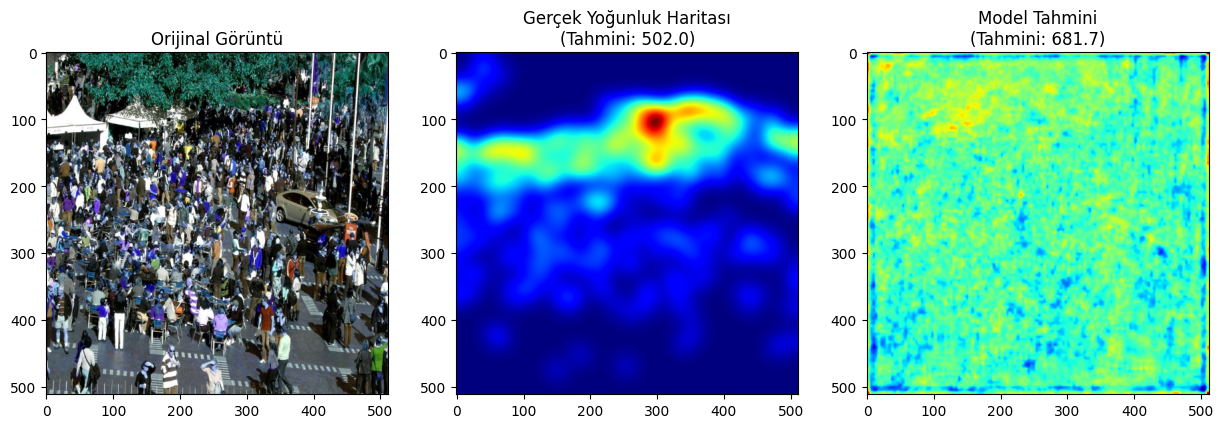

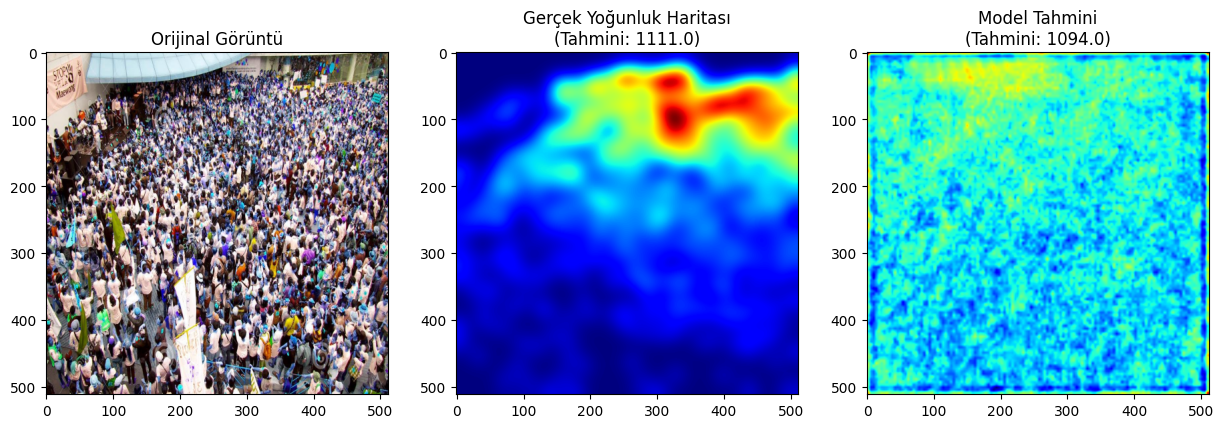

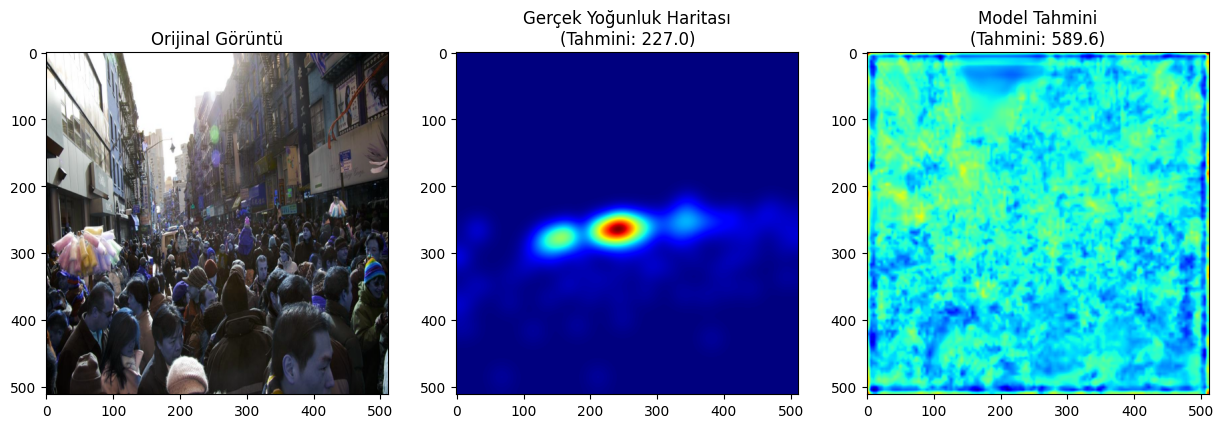

In [ ]:
def visualize_results(model, dataloader, device, num_samples=3):
    model.eval()

    with torch.no_grad():
        for i, (image, density) in enumerate(dataloader):
            if i >= num_samples:
                break

            image = image.to(device)
            density = density.to(device)

            output = model(image)

            # Çıktıyı yoğunluk haritası ile aynı boyuta getir
            if output.shape[-2:] != density.shape[-2:]:
                output = F.interpolate(output, size=density.shape[-2:], mode='bilinear', align_corners=False)

            # Görüntüyü ve yoğunluk haritalarını CPU'ya taşı
            image = image.cpu().numpy()[0].transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
            density = density.cpu().numpy()[0, 0]  # (1, H, W) -> (H, W)
            output = output.cpu().numpy()[0, 0]  # (1, H, W) -> (H, W)

            # Toplam kişi sayısını hesapla
            true_count = np.sum(density)
            pred_count = np.sum(output)

            # Görselleştir
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            ax[0].imshow(image)
            ax[0].set_title("Orijinal Görüntü")
            ax[1].imshow(density, cmap='jet')
            ax[1].set_title(f"Gerçek Yoğunluk Haritası\n(Tahmini: {true_count:.1f})")
            ax[2].imshow(output, cmap='jet')
            ax[2].set_title(f"Model Tahmini\n(Tahmini: {pred_count:.1f})")
            plt.show()

# Model tahminlerini görselleştir
visualize_results(model, test_loader, device)
